In [1]:
import tables
import numpy as np
from random import shuffle
from math import ceil
import matplotlib.pyplot as plt

In [2]:
hdf5_path = 'raw2.hdf5'  # Path where dataset.hdf5 file is stored
subtract_mean = True
batch_size = 50
nb_class = 7

In [3]:
hdf5_file = tables.open_file(hdf5_path, mode='r')
# subtract the training mean
if subtract_mean:
    mm = hdf5_file.root.train_mean[0]
    mm = mm[np.newaxis, ...]

# Total number of samples
train_data = np.array(hdf5_file.root.train_img)
train_label = np.array(hdf5_file.root.train_labels)

test_data = np.array(hdf5_file.root.test_img)
test_label = np.array(hdf5_file.root.test_labels)

val_data = np.array(hdf5_file.root.val_img)
val_label = np.array(hdf5_file.root.val_labels)

print('train data:',train_data.shape,' train_label',train_label.shape)
print('test_data:',test_data.shape,' test_label:',test_label.shape)
print(test_label)
print('val_data:',val_data.shape,' val_label:',val_label.shape)

train data: (423, 128, 128, 3)  train_label (423,)
test_data: (210, 128, 128, 3)  test_label: (210,)
[2 4 5 6 6 6 5 2 6 5 1 6 5 0 3 4 5 6 6 5 1 4 2 3 3 2 5 6 4 0 6 5 2 6 3 4 3
 1 3 4 4 3 1 4 1 4 5 0 4 2 0 2 6 3 2 4 5 6 1 3 5 1 3 5 1 2 4 3 6 4 4 4 4 6
 1 5 2 3 4 6 2 4 5 6 1 3 6 5 3 4 4 6 2 6 5 6 3 1 2 0 0 2 4 2 3 5 4 6 4 3 4
 2 6 4 4 6 3 5 2 6 3 4 2 5 6 1 5 3 3 2 4 5 6 4 5 6 6 2 0 1 3 4 3 5 4 1 4 5
 6 4 3 5 3 0 2 6 6 2 5 3 4 4 2 3 1 2 4 2 6 4 6 6 4 6 3 2 2 5 3 6 5 6 2 4 5
 4 6 5 3 4 4 3 1 4 6 5 4 3 2 4 4 4 4 0 4 6 6 5 4 4]
val_data: (211, 128, 128, 3)  val_label: (211,)


In [4]:
from keras.utils import np_utils

# one-hot encode the labels
num_classes = len(np.unique(train_label))
train_label = np_utils.to_categorical(train_label, num_classes)
test_label = np_utils.to_categorical(test_label, num_classes)
val_label = np_utils.to_categorical(val_label, num_classes)

# print shape of training set
print('num_classes:', num_classes)

# print number of training, validation, and test images
print(train_label.shape, 'train samples')
print(test_label.shape, 'test samples')
print(test_label)
print(val_label.shape, 'validation samples')


num_classes: 7
(423, 7) train samples
(210, 7) test samples
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(211, 7) validation samples


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [6]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [7]:
from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
hist = model.fit(train_data, train_label, batch_size=None, epochs=50,
          validation_data=(val_data, val_label),callbacks=[checkpointer], 
          verbose=1, shuffle=True)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.8068 - accuracy: 0.3830
Epoch 1: val_loss improved from inf to 1.42712, saving model to model.weights.best.hdf5
14/14 [==============================] - 5s 312ms/step - loss: 1.8068 - accuracy: 0.3830 - val_loss: 1.4271 - val_accuracy: 0.4787
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.9127 - accuracy: 0.6643
Epoch 2: val_loss improved from 1.42712 to 0.66363, saving model to model.weights.best.hdf5
14/14 [==============================] - 4s 300ms/step - loss: 0.9127 - accuracy: 0.6643 - val_loss: 0.6636 - val_accuracy: 0.7251
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.4800 - accuracy: 0.8109
Epoch 3: val_loss improved from 0.66363 to 0.58943, saving model to model.weights.best.hdf5
14/14 [==============================] - 4s 299ms/step - loss: 0.4800 - accuracy: 0.8109 - val_loss: 0.5894 - val_accuracy: 0.7915
Epoch 4/50
14/14 [==============================] - E

Epoch 30/50
14/14 [==============================] - ETA: 0s - loss: 9.2718e-04 - accuracy: 1.0000
Epoch 30: val_loss did not improve from 0.35347
14/14 [==============================] - 4s 292ms/step - loss: 9.2718e-04 - accuracy: 1.0000 - val_loss: 0.3896 - val_accuracy: 0.8910
Epoch 31/50
14/14 [==============================] - ETA: 0s - loss: 8.0360e-04 - accuracy: 1.0000
Epoch 31: val_loss did not improve from 0.35347
14/14 [==============================] - 4s 291ms/step - loss: 8.0360e-04 - accuracy: 1.0000 - val_loss: 0.3939 - val_accuracy: 0.8863
Epoch 32/50
14/14 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000
Epoch 32: val_loss did not improve from 0.35347
14/14 [==============================] - 4s 299ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.3980 - val_accuracy: 0.8910
Epoch 33/50
14/14 [==============================] - ETA: 0s - loss: 7.4520e-04 - accuracy: 1.0000
Epoch 33: val_loss did not improve from 0.35347
14/14 [========

In [8]:
model.load_weights('model.weights.best.hdf5')

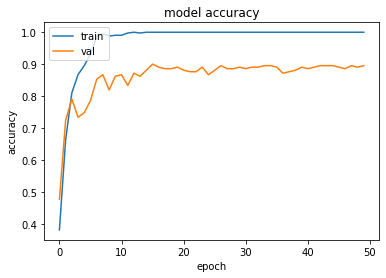

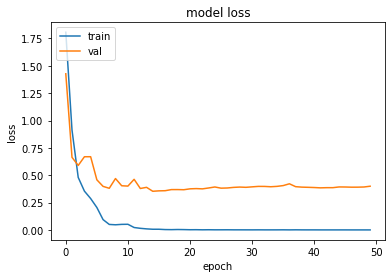

In [9]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
score = model.evaluate(test_data, test_label, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8857142925262451


In [11]:
import pandas as pd

print(test_label)
predictions = model.predict(test_data)
predictions = pd.DataFrame(predictions)
print(predictions.idxmax(axis=1))

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
0      2
1      4
2      5
3      6
4      6
      ..
205    6
206    6
207    5
208    1
209    4
Length: 210, dtype: int64


In [12]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [13]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[2 4 5 6 6 6 5 2 6 5 1 1 5 0 3 4 5 1 6 2 1 4 2 3 4 2 5 6 6 0 1 5 2 6 3 4 4
 1 3 4 4 3 1 4 1 4 5 0 4 2 0 2 1 3 2 4 2 6 1 4 5 1 3 5 1 2 4 3 6 4 1 4 4 6
 1 5 2 3 4 6 2 4 5 6 1 3 6 5 3 4 4 6 2 6 5 1 3 1 2 0 0 2 4 2 3 5 4 6 4 3 4
 2 6 4 4 6 3 5 2 6 3 1 2 5 6 1 5 3 4 5 4 5 6 4 5 6 6 2 5 4 3 4 3 5 4 1 4 5
 6 1 3 5 3 0 2 6 6 5 2 3 4 4 4 3 1 5 4 2 6 4 4 6 4 6 3 2 2 5 3 6 5 6 2 4 5
 4 6 5 3 4 4 3 1 4 6 5 4 3 2 4 4 4 4 0 4 6 6 5 1 4]
Confusion matrix, without normalization
[[ 8  0  0  0  0  1  0]
 [ 0 15  0  0  1  0  0]
 [ 0  0 25  0  1  3  0]
 [ 0  0  0 28  4  0  0]
 [ 0  4  0  0 46  0  1]
 [ 0  0  3  0  0 29  0]
 [ 0  5  0  0  1  0 35]]


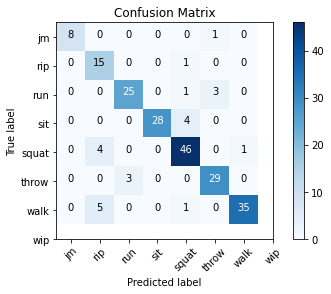

In [14]:
tests = model.predict(test_data)
tests = np.argmax(tests,axis = 1) 
print(tests)
cm_plot_labels = ['jm','rip', 'run','sit','squat','throw','walk','wip']

cm = confusion_matrix(y_true=np.argmax(test_label,axis = 1), y_pred=tests)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,title='Confusion Matrix')